<a href="https://colab.research.google.com/github/remifol/SystematicReview/blob/master/TripletLoss_AlreadyImplemented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To run this model directly in the browser with zero setup, open it in [Colab here](https://colab.research.google.com/github/sararob/keras-wine-model/blob/master/keras-wide-deep.ipynb).

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import itertools
import os
import math
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import tensorflow as tf
import nltk
import time
import gensim
import random

import pickle
import itertools

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model, svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, recall_score

from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from keras.utils import Sequence
layers = keras.layers

from google.colab import drive
drive.mount('/content/drive')
Path = 'drive/My Drive/Projet de maitrise/Revue systématique/Automatisation/Algorithme/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Using TensorFlow backend.


In [0]:
def embed(model,word_list, max_N_word):
  #get a padded list of word, return a ndarray of dimension [Max_N_word, Embed_dim]
  Emb_size = model.vector_size
  embed_words = np.zeros((max_N_word,Emb_size))
  embeded = []
  for word in word_list:
    try :
      embeded.append(model.get_vector(word))
    except KeyError: #unkown word
      embeded.append(np.zeros(Emb_size)) #unkown tag
  embed_words[:len(word_list),:] = np.asarray(embeded)
  
  return embed_words

In [0]:
#Declarations
Last_Layer_size = 128
shape = (410,128)

In [0]:
with open(Path+'mylist', 'rb') as f:
  Article = pickle.load(f)
Articles_df = pd.DataFrame(Article, columns = ['TitleAbstract','Label','drop'])
Articles_df.drop(columns = ['drop'], inplace=True)

Articles_df = Articles_df.sample(frac=1)

#count unique words
words = []
_ = [words.extend(x) for x in Articles_df['TitleAbstract']]
Nb_words = len(set(words))
del words

#Count maximum length
art_length = max(Articles_df['TitleAbstract'].apply(len))
                                                        
#Embed
model = gensim.models.KeyedVectors.load_word2vec_format(Path + "Models/ACEInhibitors_word2vec_128.bin", binary=True)

Articles_df['Embed'] = Articles_df['TitleAbstract'].apply(lambda x:embed(model,x, art_length))
Articles_df['Label_resize'] = Articles_df['Label'].apply(lambda x:np.ones(Last_Layer_size)*x)

#Train and test subsets.
Id_train = len(Articles_df)//2

Articles_test = Articles_df[:Id_train]
Articles_train = Articles_df[Id_train:]

#Format
x_train = np.zeros((len(Articles_train),shape[0],shape[1]))

for i in range(len(Articles_train)):
    x_train[i,:,:] = Articles_train['Embed'].values[i]
    
y_train = np.zeros((len(Articles_train),Last_Layer_size))

for i in range(len(Articles_train)):
    y_train[i,:] = Articles_train['Label_resize'].values[i]

In [6]:
# Define our deep model with the Functional API

Inp = layers.Input(shape=(shape[0],shape[1],))

flat = layers.Conv1D(64,kernel_size=5, data_format = 'channels_first')(Inp)
flat = layers.LSTM(64)(flat)
flat = layers.Flatten()(flat)
dense1 = layers.Dense(128, activation = "softmax")(flat)
drop2 = layers.Dropout(0.5)(dense1)
dense2 = layers.Dense(Last_Layer_size)(drop2)
deep_net = layers.Lambda(lambda x: keras.backend.l2_normalize(x, axis=1))(dense2)

deep_model = keras.Model(inputs=Inp, outputs=deep_net)
print(deep_model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 410, 128)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 64, 124)           131264    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                48384     
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)    

In [0]:
def custom_loss(margin):

    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def loss(y_true,y_pred):
        label = keras.backend.mean(y_true, axis=-1)
        return tf.contrib.losses.metric_learning.triplet_semihard_loss(embeddings = y_pred, labels = label, margin = margin)
   
    # Return a function
    return loss

In [0]:
deep_model.compile(loss=custom_loss(0.8), optimizer='adam')

In [20]:
deep_model.fit(x = x_train, y = y_train, batch_size = 128, epochs = 20)

Epoch 1/20
1101/1101 [==============================] - 3s 3ms/sample - loss: 0.0314
Epoch 2/20
1101/1101 [==============================] - 2s 2ms/sample - loss: 0.0175
Epoch 3/20
1101/1101 [==============================] - 2s 2ms/sample - loss: 0.0171
Epoch 4/20
1101/1101 [==============================] - 2s 2ms/sample - loss: 0.0100
Epoch 5/20
1101/1101 [==============================] - 2s 2ms/sample - loss: 0.0052
Epoch 6/20
1101/1101 [==============================] - 2s 2ms/sample - loss: 0.0040
Epoch 7/20
1101/1101 [==============================] - 2s 2ms/sample - loss: 0.0326
Epoch 8/20
1101/1101 [==============================] - 2s 2ms/sample - loss: 0.0137
Epoch 9/20
1101/1101 [==============================] - 2s 2ms/sample - loss: 0.0108
Epoch 10/20
1101/1101 [==============================] - 2s 2ms/sample - loss: 0.0027
Epoch 11/20
1101/1101 [==============================] - 2s 2ms/sample - loss: 0.0488
Epoch 12/20
1101/1101 [==============================] - 2s 2ms

In [0]:
svm_BOW = linear_model.SGDClassifier(loss = 'hinge',
                                     penalty = 'l2', 
                                     max_iter =  10000,
                                     tol=1e-5)


In [24]:
x_embed = deep_model.predict(x_train)
x_valid_embed = deep_model.predict(np.stack(Articles_test['Embed'].values.tolist()))

_ = svm_BOW.fit(x_embed, Articles_train['Label'])

y_predict = svm_BOW.predict(x_valid_embed)


Acc = accuracy_score(Articles_test['Label'],y_predict, normalize=True)
print('Accuracy : {0:0.4f}'.format(Acc))

Sn = recall_score(Articles_test['Label'],y_predict, pos_label=1)
print('Sensitivity : {0:0.4f}'.format(Sn))

Sp = recall_score(Articles_test['Label'],y_predict, pos_label=0)
print('Specificity : {0:0.4f}'.format(Sp))

Accuracy : 0.8991
Sensitivity : 0.0610
Specificity : 0.9666


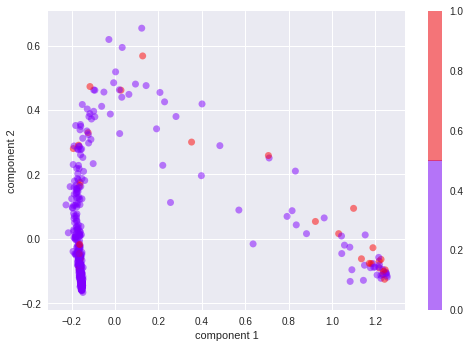

In [118]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

projected = PCA(2).fit_transform(x_valid_embed)

plt.scatter(projected[:, 0], projected[:, 1],
            c=Articles_test['Label'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('rainbow', 2))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [0]:
X_embedded.shape

In [0]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
            c=y_valid, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [0]:
0.67156960180216

In [0]:
len(y_valid)